# **Equity Portfolio Construction & Stock Selection with ML**
---
### K-means Algorithm

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import skew, kurtosis

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.stats.mstats import winsorize

## **Data**
---

We retrieve stock data (daily closing price) from the `Yahoo Finance` API for the following 3 years period : `start="2022-01-01"` to `end="2025-01-01"`.

The period selected for computing market-based features spans from January 2022 to January 2025. This time window was chosen in order to capture a wide range of market conditions while remaining representative of the current financial environment.

This period includes several distinct market regimes. The year 2022 corresponds to a bear market marked by rising inflation, aggressive monetary tightening, and a strong sell-off in growth and technology stocks. The year 2023 represents a transition phase, with market stabilization and gradual normalization. Finally, 2024 is characterized by a renewed bull market, driven in part by strong performance in technology and artificial intelligence-related stocks. As a result, the selected window captures macroeconomic shocks, sector rotations, and regime changes, which are essential for building a meaningful structural clustering of stocks.

From a statistical perspective, this choice provides approximately 750 daily observations per stock, which is sufficient to obtain robust estimates of volatility, skewness, kurtosis, beta, and maximum drawdown. This improves the stability of the features used by the K-means algorithm and reduces sensitivity to short-term noise or isolated events.

Moreover, this time window allows for a clear discrimination between different equity styles. It effectively separates growth versus value stocks, high-beta versus defensive stocks, momentum winners versus laggards, and small-, mid-, and large-cap firms. At the same time, the period is not excessively long, avoiding distortions related to pre-2020 market dynamics or the extreme COVID-19 crisis. Overall, the 2022–2025 window offers a balanced trade-off between statistical robustness, economic relevance, and interpretability for clustering purposes.

In [25]:
def get_wikipedia_tickers(url):

    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    response = requests.get(url, headers=headers)
    
    df_list = pd.read_html(response.text)
    df = df_list[0]  
    
    tickers = df['Symbol'].tolist()
    
    return tickers

In [45]:
url_sp600 = "https://en.wikipedia.org/wiki/List_of_S%26P_600_companies"
url_sp400 = "https://en.wikipedia.org/wiki/List_of_S%26P_400_companies"
url_sp500 = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

sp600_tickers = get_wikipedia_tickers(url_sp600)
sp400_tickers = get_wikipedia_tickers(url_sp400)
sp500_tickers = get_wikipedia_tickers(url_sp500)

print("S&P 600 tickers count:", len(sp600_tickers))
print("S&P 400 tickers count:", len(sp400_tickers))
print("S&P 500 tickers count:", len(sp500_tickers))

/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_9375/2049066917.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(response.text)
/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_9375/2049066917.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(response.text)


S&P 600 tickers count: 602
S&P 400 tickers count: 401
S&P 500 tickers count: 503


/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_9375/2049066917.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(response.text)


In [ ]:
tickers_sp500 = [t.replace('.', '-') for t in sp500_tickers]
tickers_sp400 = [t.replace('.', '-') for t in sp400_tickers]
tickers_sp600 = [t.replace('.', '-') for t in sp600_tickers]

delisted_tickers = ['SNDK', 'Q', 'SOLS', 'MRP', 'RAL'] + ['GEHC', 'GEV', 'KVUE', 'SOLV', 'VLTO'] + ['CART', 'CAVA', 'CR', 'KNF', 'NXT', 'TLN'] + ['AESI', 'AMTM', 'BTSG', 'CON', 'CURB', 'ECG', 'FTRE', 'KGS', 'MBC', 'NATL', 'PHIN', 'RXO', 'SEZL', 'VSTS', 'WAY', 'WS']

tickers_sp500 = [t for t in tickers_sp500 if t not in delisted_tickers]
tickers_sp400 = [t for t in tickers_sp400 if t not in delisted_tickers]
tickers_sp600 = [t for t in tickers_sp600 if t not in delisted_tickers]

tickers = tickers_sp500 + tickers_sp400 + tickers_sp600

def get_data(tickers, start="2022-01-01", end="2025-01-01", min_valid=0.9):
    df = yf.download(tickers, start=start, end=end, progress=False)["Close"]
    df = df.dropna(axis=1, thresh=len(df) * min_valid)
    return df

df_sp500 = get_data(tickers_sp500)
df_sp400 = get_data(tickers_sp400)
df_sp600 = get_data(tickers_sp600)

stock_data = pd.concat([df_sp500, df_sp400, df_sp600], axis=1)

print("Dataframe size:", stock_data.shape)
stock_data.info()
stock_data.head()

/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_9375/2631040078.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end, progress=False)["Close"]
/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_9375/2631040078.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end, progress=False)["Close"]
/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_9375/2631040078.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end, progress=False)["Close"]


Dataframe size: (753, 1474)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2022-01-03 to 2024-12-31
Columns: 1474 entries, A to ZWS
dtypes: float64(1474)
memory usage: 8.5 MB


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WT,WU,WWW,XHR,XNCR,XPEL,YELP,YOU,ZD,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,152.320038,178.270355,116.779282,172.679993,128.996124,42.362530,383.711914,564.369995,165.041641,60.489784,...,5.873550,13.743546,26.302092,16.514124,41.630001,71.779999,36.919998,28.473043,113.169998,34.922157
2022-01-04,147.170700,176.007782,116.555092,170.800003,125.962357,42.914051,380.969849,554.000000,163.550995,61.612450,...,5.939125,13.669373,25.510239,16.630293,41.090000,69.750000,36.779999,26.810251,113.199997,35.615593
2022-01-05,144.649567,171.326004,117.167358,162.250000,125.396439,42.410072,374.260712,514.429993,161.026215,61.131294,...,5.901653,13.684209,24.979338,15.861779,39.259998,66.440002,35.299999,24.056812,107.940002,34.334663
2022-01-06,145.155685,168.465973,116.615448,159.750000,125.377846,42.657307,356.187500,514.119995,161.538651,61.674824,...,5.948492,13.602621,25.195299,16.013695,39.470001,68.650002,35.700001,23.162840,108.160004,34.190201
2022-01-07,141.291229,168.632446,116.313637,166.050003,125.767532,42.856995,349.355896,510.700012,157.299622,62.200500,...,6.051537,14.099554,24.448439,16.406887,37.970001,66.500000,35.299999,23.404215,107.080002,33.390831


Then we collect fundamental data (PE Ratio, ROE, Debt to Equity, Market Cap, Beta) for each stock with the same API.

Preprocessing par SP. Mettre la mediane pour les missign values

In [49]:
fundamentals = []

for t in tickers:
    try:
        tk = yf.Ticker(t)
        info = tk.info
        fundamentals.append({
            "ticker": t,
            "pe_ratio": info.get("trailingPE"),
            "roe": info.get("returnOnEquity"),
            "debt_to_equity": info.get("debtToEquity"),
            "market_cap": info.get("marketCap"),
            "liquidity": info.get("averageVolume"),
            #"dividend_yield": info.get("dividendYield")
        })
    except Exception as e:
        print(f"Failed for {t}: {e}")

fundamentals_df = pd.DataFrame(fundamentals).set_index("ticker")

numeric_cols = ["pe_ratio", "roe", "debt_to_equity", "market_cap", "liquidity"] # div yield

for col in numeric_cols:
    fundamentals_df[col] = pd.to_numeric(fundamentals_df[col], errors="coerce")

print("Dataframe size:", fundamentals_df.shape)
print("Dataframe size:", fundamentals_df.info())

fundamentals_df.head()

Dataframe size: (1501, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 1501 entries, MMM to ZWS
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pe_ratio        1303 non-null   float64
 1   roe             1445 non-null   float64
 2   debt_to_equity  1320 non-null   float64
 3   market_cap      1501 non-null   int64  
 4   liquidity       1501 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 70.4+ KB
Dataframe size: None


,pe_ratio,roe,debt_to_equity,market_cap,liquidity
ticker,,,,,
MMM,25.823248,0.72921,281.904,86376554496,3029135
AOS,18.350405,0.28209,12.063,9540022272,1252211
ABT,15.918342,0.30620,25.310,220533555200,6300991
ABBV,169.931810,1.37961,NaN,396442042368,6035556
ACN,22.530040,0.25509,25.380,180764999680,4540216


## **Features**
---

### **Input Data**

Stock data from SP500 (US large cap), SP600 (US small cap) and SP400 (US mid cap) : $X^{\intercal}=[x^{(1)}, x^{(3)}, ... , x^{(N)}]$

### **Feature Engineering & Selection**

To construct a robust clustering model, we selected features that capture three distinct dimensions of asset behavior: **Market Dynamics**, **Financial Health**, and **Statistical Tail Risk**.

**1) Risk & Return Metrics**

These features quantify how an asset moves relative to itself and the broader market.

- **Realized Volatility:** Annualized standard deviation of daily returns
- **Beta ($\beta$):** Sensitivity to the broader market (e.g., S&P 500)
- **12 Months -1 Momentum:** ???
- **Max drawdown:** The maximum observed percentage decline from a historical peak. It measures the worst-case scenario for an asset’s value preservation.

**2) Fundamental Metrics**

We incorporate fundamental data to ensure selected stocks possess strong valuation and solvency metrics. These cluster stocks based on their company valuation and financial health.

- **Valuation:** P/E Ratio
- **Profitability:** ROE (Return on Equity)
- **Leverage:** Debt-to-Equity ratio
- **Size:** Market Capitalization

**3) Statistical Moments**

Beyond standard volatility, we examine the distribution of returns to quantify tail risk i.e. the likelihood of rare, extreme negative events.

- **Skewness:** Measure of asymmetry in returns distribution.
- **Kurtosis:** Measure of "tail risk" (extreme events).

### **Remarks**

#### Momentum 12-1 Months (Using Log Returns)

**Definition**  
The 12-1 month momentum measures the cumulative return of a stock over the past 12 months, excluding the most recent month, using log returns. Using log returns ensures additivity over time and numerical stability:

$$
\text{Momentum}_{12-1} = \sum_{t=-12}^{-1} r_t^{\text{log}}
$$

where $r_t^{\text{log}} = \log(1 + r_t^{\text{simple}})$ are the monthly log returns.


**Why This Metric is Preferred Over Average Returns**  

- **Captures medium-term trends:** Focuses on the past year’s performance while ignoring very recent noise.  
- **Reduces short-term reversals:** Excludes the last month to avoid distortions from mean-reversion.  
- **More stable than average returns:** Average returns are sensitive to daily volatility and outliers, while cumulative log returns over 12 months provide a smoother trend measure.

**Why Not the Sharpe Ratio**  

- Sharpe ratio combines return and volatility.  
- We already include **separate features for return and volatility**.  
- Using Sharpe ratio would double-count information and reduce interpretability for clustering.


In [ ]:
def momentum_12_1(series, window=252, skip=21):
    log_returns = np.log(1 + series)
    return log_returns.iloc[-window:-skip].sum()

def max_drawdown_log(series, window=750):
    cum = np.exp(series.iloc[-window:].cumsum())
    peak = np.maximum.accumulate(cum)
    dd = (cum - peak) / peak
    return dd.min()

# weights should be market cap
def beta(stock_log_returns, market_log_returns, window=750):
    df = pd.concat([stock_log_returns, market_log_returns], axis=1).dropna()
    stock_aligned = df.iloc[-window:, 0]
    market_aligned = df.iloc[-window:, 1]
    
    cov = np.cov(stock_aligned, market_aligned, ddof=1)[0,1]
    var_market = np.var(market_aligned, ddof=1)
    
    beta = cov / var_market
    return beta

def skewness(series):
    series = series.dropna()
    return skew(series, bias=False)

def kurt(series):
    series = series.dropna()
    return kurtosis(series, bias=False)

We use the log returns because they are additive and more statistically stable (standard approach in quantitative finance).

In [69]:
returns = stock_data.pct_change().dropna()
log_returns = np.log(1 + returns)

sp500_returns = df_sp500.pct_change().dropna()
sp500_log_returns = np.log(1 + sp500_returns)
sp500_market = sp500_log_returns.mean(axis=1)

sp600_returns = df_sp600.pct_change().dropna()
sp600_log_returns = np.log(1 + sp600_returns)
sp600_market = sp600_log_returns.mean(axis=1)

sp400_returns = df_sp600.pct_change().dropna()
sp400_log_returns = np.log(1 + sp400_returns)
sp400_market = sp400_log_returns.mean(axis=1)


tickers_sp400 = [t for t in tickers_sp500 if t not in ['CART', 'CAVA', 'CR', 'KNF', 'NXT', 'TLN']]
tickers_sp600 = [t for t in tickers_sp600 if t not in ['AESI', 'AMTM', 'BTSG', 'CON', 'CURB', 'ECG', 'FTRE', 'KGS', 'MBC', 'NATL', 'PHIN', 'RXO', 'SEZL', 'VSTS', 'WAY', 'WS']]

In [101]:
X = pd.DataFrame(index=log_returns.columns)

X["volatility"] = log_returns.std() * np.sqrt(252)
#X["momentum"] = log_returns.apply(quarterly_momentum, window=63)
X["momentum_12_1"] = log_returns.apply(momentum_12_1, window=252, skip=21)
X["max_drawdown"] = log_returns.apply(max_drawdown_log)
X["skewness"] = log_returns.apply(skewness)
X["kurtosis"] = log_returns.apply(kurt)

# Beta
X['beta'] = np.nan
X.loc[tickers_sp500, 'beta'] = log_returns[tickers_sp500].apply(lambda x: beta(x, sp500_market))
X.loc[tickers_sp400, 'beta'] = log_returns[tickers_sp400].apply(lambda x: beta(x, sp400_market))
X.loc[tickers_sp600, 'beta'] = log_returns[tickers_sp600].apply(lambda x: beta(x, sp600_market))



# P/E ratio
pe_winsor = winsorize(fundamentals_df['pe_ratio'], limits=[0.01, 0.01])
pe_winsor = pd.Series(pe_winsor, index=fundamentals_df.index)
pe_aligned = pe_winsor.loc[X.index]
pe_aligned = pe_aligned.clip(lower=0.01)
X['pe_ratio'] = np.log(pe_aligned)
X['pe_ratio'].replace(np.inf, np.nan, inplace=True)


roe_winsor = winsorize(fundamentals_df['roe'], limits=[0.05, 0.05])
roe_winsor = pd.Series(roe_winsor, index=fundamentals_df.index)
roe_aligned = roe_winsor.loc[X.index]
X['roe'] = roe_aligned


X['debt_to_equity'] = fundamentals_df['debt_to_equity'] 
X['daily_volume'] = np.log(fundamentals_df['liquidity'])
#X['dividend_yield'] = fundamentals_df['dividend_yield']
X['market_cap'] = np.log(fundamentals_df['market_cap'])


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_9375/3084828423.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['pe_ratio'].replace(np.inf, np.nan, inplace=True)


In [102]:
print(X.shape)

(1474, 11)


In [106]:
print(X.info())

X = X.dropna()

print("Final feature matrix shape:", X.shape)

X.head()

<class 'pandas.core.frame.DataFrame'>
Index: 805 entries, A to ZWS
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   volatility      805 non-null    float64
 1   momentum_12_1   805 non-null    float64
 2   max_drawdown    805 non-null    float64
 3   skewness        805 non-null    float64
 4   kurtosis        805 non-null    float64
 5   beta            805 non-null    float64
 6   pe_ratio        805 non-null    float64
 7   roe             805 non-null    float64
 8   debt_to_equity  805 non-null    float64
 9   daily_volume    805 non-null    float64
 10  market_cap      805 non-null    float64
dtypes: float64(11)
memory usage: 75.5+ KB
None
Final feature matrix shape: (805, 11)


,volatility,momentum_12_1,max_drawdown,skewness,kurtosis,beta,pe_ratio,roe,debt_to_equity,daily_volume,market_cap
Ticker,,,,,,,,,,,
A,0.293022,-0.035362,-0.360411,0.031737,2.847117,0.740140,3.400174,0.20619,49.755,14.432925,24.380220
AAPL,0.267778,0.189756,-0.296203,0.022925,2.482718,0.660009,3.597000,1.25346,152.411,17.703043,29.025832
ABNB,0.451888,-0.055079,-0.534007,-0.524063,3.349974,1.158249,3.461112,0.30776,26.458,15.408523,25.128824
ABT,0.213455,0.080596,-0.247474,0.084294,2.954111,0.426801,2.767472,0.30620,25.310,15.656217,26.119316
ACGL,0.255296,0.331033,-0.187788,-0.137360,3.047116,0.347237,2.195766,0.17811,11.501,14.615104,24.300881


In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805 entries, A to ZWS
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   volatility      805 non-null    float64
 1   momentum_12_1   805 non-null    float64
 2   max_drawdown    805 non-null    float64
 3   skewness        805 non-null    float64
 4   kurtosis        805 non-null    float64
 5   beta            805 non-null    float64
 6   pe_ratio        805 non-null    float64
 7   roe             805 non-null    float64
 8   debt_to_equity  805 non-null    float64
 9   daily_volume    805 non-null    float64
 10  market_cap      805 non-null    float64
dtypes: float64(11)
memory usage: 75.5+ KB


In [77]:
X.describe()

,volatility,momentum_12_1,max_drawdown,skewness,kurtosis,beta,pe_ratio,roe,debt_to_equity,daily_volume,market_cap
count,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000
mean,0.349631,0.125715,-0.387241,-0.336922,10.113564,0.816393,3.237597,0.208843,136.405729,14.165459,23.147557
std,0.124775,0.313945,0.148995,1.420221,25.944375,0.326288,0.743768,0.237137,287.465483,1.359415,1.784629
min,0.153519,-1.192453,-0.893437,-21.371141,0.330801,0.082608,1.806612,-0.016710,0.002000,9.938951,19.396655
25%,0.260428,-0.035362,-0.470234,-0.541080,2.544047,0.593396,2.779747,0.081290,31.114000,13.224019,21.685874
50%,0.323237,0.139075,-0.348696,-0.160998,5.012593,0.810139,3.156663,0.131010,68.064000,14.149659,22.991684
75%,0.410010,0.297040,-0.274640,0.147541,9.592397,1.022974,3.534983,0.230410,138.918000,15.003179,24.467710
max,1.144451,1.915323,-0.144787,5.855787,524.447445,2.583918,7.708860,1.253460,4217.211000,19.069573,29.056987


### Scaling of the data

In [78]:
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

X_scaled.describe()

,volatility,momentum_12_1,max_drawdown,skewness,kurtosis,beta,pe_ratio,roe,debt_to_equity,daily_volume,market_cap
count,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000
mean,0.176451,-0.040193,-0.197065,-0.255473,0.723711,0.014559,0.107165,0.521952,0.633944,0.008881,0.056032
std,0.834158,0.944473,0.761758,2.062413,3.680915,0.759555,0.984815,1.590246,2.666557,0.764077,0.641529
min,-1.134616,-4.005767,-2.785069,-30.800889,-0.664239,-1.693594,-1.787586,-0.990612,-0.631349,-2.366682,-1.292322
25%,-0.419896,-0.524777,-0.621378,-0.551947,-0.350230,-0.504547,-0.499070,-0.333423,-0.342752,-0.520268,-0.469406
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.580104,0.475223,0.378622,0.448053,0.649770,0.495453,0.500930,0.666577,0.657248,0.479732,0.530594
max,5.490053,5.343662,1.042515,8.737438,73.695947,4.129124,6.027513,7.527159,38.487876,2.765301,2.180324


## Determine the optimal K (Elbow Method + Silhouette)

When applying a clustering algorithm like **K-Means**, a crucial step is to determine the **optimal number of clusters**, denoted \(k\). Two commonly used methods are: **Elbow Method** and **Silhouette Analysis**.


### Elbow Method

The **Elbow Method** consists of plotting the **Intertia** as a function of $k$:

$$
\text{Intertia} = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - \mu_i \|^2
$$

- $C_i$ : cluster $i$  
- $\mu_i$ : centroid of cluster $i$  

**Interpretation:** As $k$ increases, inertia decreases because points are closer to their centroids. We look for the **“elbow” point**, where the improvement starts to level off. This point represents a good balance between **complexity** and **clustering quality**.


### Silhouette Analysis

The **silhouette score** measures how well a point is **clustered with its own cluster** and **separated from other clusters**.

For a point $i$:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

- $a(i)$ : average distance to other points in the same cluster  
- $b(i)$ : average distance to the nearest cluster  

**Properties:**  
- $s(i) \in [-1, 1]$
  - $s(i) \approx 1$ : well-clustered point  
  - $s(i) \approx 0$ : point on the border between clusters  
  - $s(i) < 0$ : poorly assigned point  

**Interpretation for choosing $k$**: Compute the **average silhouette score** over all points. The $k$ that maximizes the average score is considered the best choice.


## Comparison of Methods

| Method | Advantages | Limitations |
|--------|-----------|------------|
| Elbow  | Simple to visualize | Subjective; elbow may not be clear |
| Silhouette | Quantitative; easy interpretation | May favor fewer clusters |



In [79]:
inertia = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)  
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

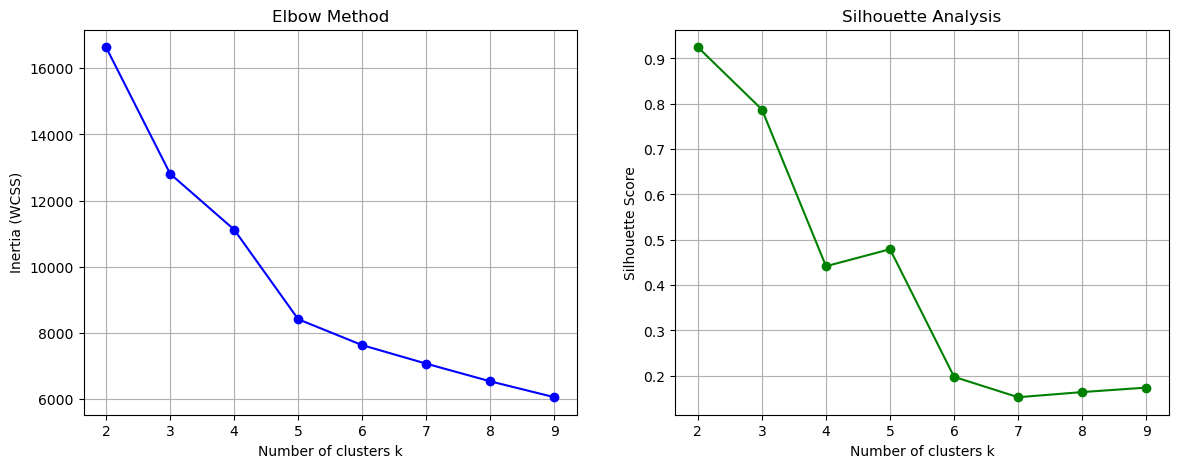

Best k according to silhouette: 2


In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# Elbow method
ax1.plot(K_range, inertia, marker='o', color='blue')
ax1.set_xlabel("Number of clusters k")
ax1.set_ylabel("Inertia (WCSS)")
ax1.set_title("Elbow Method")
ax1.grid(True)

# Silhouette scores
ax2.plot(K_range, sil_scores, marker='o', color='green')
ax2.set_xlabel("Number of clusters k")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Analysis")
ax2.grid(True)

plt.show()

# Best k according to silhouette
best_k = K_range[np.argmax(sil_scores)]
print("Best k according to silhouette:", best_k)

In [114]:
n_clusters = 5
random_state = 42
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
labels = kmeans.fit_predict(X_scaled)
X["cluster"] = labels

print("\nCluster counts:")
print(X["cluster"].value_counts())


Cluster counts:
cluster
0    704
4     61
3     32
2      6
1      2
Name: count, dtype: int64


### **Analyse des clusters**

Volatility : high/low → risque du cluster

Momentum / Momentum 12-1 : cluster “growth” ou “value”

Max Drawdown : stabilité historique

PE ratio / ROE / Debt-to-Equity : style de valorisation / solidité financière

Market Cap : small/mid/large caps

Daily Volume : liquidité

In [115]:
X.groupby(labels).mean()

,volatility,momentum_12_1,max_drawdown,skewness,kurtosis,beta,pe_ratio,roe,debt_to_equity,daily_volume,market_cap,cluster
0,0.343847,0.128970,-0.378506,-0.153858,6.740440,0.817849,3.247093,0.157689,84.424970,14.121237,23.127237,0.0
1,0.657328,-0.427622,-0.691233,-18.774272,448.433400,0.690310,2.390898,0.124090,67.944500,13.649132,21.388557,1.0
2,0.305253,0.220814,-0.288822,0.157582,6.758145,0.722213,2.821670,1.060728,2725.508333,14.312339,22.402892,2.0
3,0.455201,-0.182351,-0.556888,-3.569356,62.044458,0.832548,3.307383,0.151331,71.870469,14.195747,22.669547,3.0
4,0.355278,0.258538,-0.398770,-0.198095,7.759193,0.804512,3.160066,0.748378,517.748180,14.662420,23.763750,4.0


🔵 Cluster 1 — Large cap défensives
	•	low volatility
	•	low beta
	•	large market cap
	•	drawdown modéré

🔴 Cluster 2 — Growth risquées
	•	high momentum
	•	high volatility
	•	forte kurtosis
	•	drawdowns profonds

🟢 Cluster 3 — Value cycliques
	•	PE faible
	•	ROE moyen
	•	beta > 1

🟣 Cluster 4 — Small caps spéculatives
	•	small cap
	•	skewness négative
	•	très forte volatilité

Parfait pour diversification

In [2]:
# UMAP à la place de PCA

In [117]:
# Tu verras si un cluster est majoritairement small caps, ou s’il mélange toutes tailles. Comment small, mid et large cap se répartissent
fundamentals_df['cap_category'] = pd.qcut(fundamentals_df['market_cap'], 3, labels=['Small','Mid','Large'])
X['cap_category'] = fundamentals_df.loc[X.index, 'cap_category']

# Comptage par cluster
print(X.groupby(['cluster','cap_category']).size())

cluster  cap_category
0        Small           248
         Mid             130
         Large           326
1        Small             1
         Mid               1
         Large             0
2        Small             3
         Mid               1
         Large             2
3        Small            15
         Mid               6
         Large            11
4        Small            13
         Mid              14
         Large            34
dtype: int64


/var/folders/5s/_mm2kbzx0hb04_mrx65lzgbr0000gn/T/ipykernel_9375/491404547.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X.groupby(['cluster','cap_category']).size())
